In [1]:
#importovanje neophodnih biblioteka
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
#scikit learn preprocesiranje
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
#scikit learn selekcija feature-a
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
#scikit learn izbor modela
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
#sklearn metrike 
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix, r2_score
#sklearn modeli
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression, LassoCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
#sklearn model selection
from sklearn.model_selection import GridSearchCV
#sklearn za crossvalidation
from sklearn.model_selection import cross_val_score, cross_validate
#feature reduction sa PCA
from sklearn.decomposition import PCA
#za handlovanje nebalansiranih datasetova
from imblearn.over_sampling import SMOTE
import shap
from lime import lime_tabular
import eli5
from eli5.sklearn import PermutationImportance
#sklearn genetic-opt
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn_genetic.plots import plot_fitness_evolution
from sklearn_genetic import GAFeatureSelectionCV

In [2]:
#ucitavanje podataka
file_name = "./addiction_nova.csv"
data = pd.read_csv(file_name, na_values = ' ')
data.head(10)

ID  Pol  Godine  SkolaPoTipu  SkolaPoRegionu  Uspeh  EkonomskiPolozaj  \
0   1  0.0    17.0            1               1    3.0               3.0   
1   2  0.0    17.0            1               1    4.0               4.0   
2   3  0.0    17.0            1               1    4.0               3.0   
3   4  0.0    17.0            1               1    4.0               3.0   
4   5  0.0    17.0            1               1    4.0               1.0   
5   6  0.0    17.0            1               1    4.0               3.0   
6   7  0.0    16.0            1               1    4.0               5.0   
7   8  0.0    16.0            1               1    3.0               5.0   
8   9  1.0    17.0            1               1    5.0               2.0   
9  10  0.0    16.0            1               1    4.0               1.0   

   ImaKomp  ZadovoljanPristupom  KolikoDugo  ...  Internet16  Internet17  \
0      0.0                  1.0         9.0  ...         5.0         5.0   
1      0.0                  1.0         5.0  ...         1.0         2.0   
2      0.0                  1.0         9.0  ...         3.0         1.0   
3      0.0                  1.0         7.0  ...         4.0         1.0   
4      1.0                  0.0         2.0  ...         2.0         1.0   
5      0.0                  1.0         6.0  ...         4.0         1.0   
6      0.0                  1.0         5.0  ...         1.0         2.0   
7      0.0                  1.0         8.0  ...         2.0         1.0   
8      0.0                  1.0         5.0  ...         5.0         2.0   
9      0.0                  0.0         6.0  ...         4.0         1.0   

   Internet18   NKP    PI   SPO   PUI  PUIcutoff  CutOff3940  CutOff4950  
0         NaN   NaN  16.0  11.0   NaN        NaN         NaN         NaN  
1         1.0  13.0   7.0   5.0  25.0        0.0         0.0         0.0  
2         1.0  13.0   9.0   6.0  28.0        0.0         0.0         0.0  
3         1.0  12.0  14.0   5.0  31.0        0.0         0.0         0.0  
4         2.0  12.0   9.0   7.0  28.0        0.0         0.0         0.0  
5         2.0  17.0  10.0   5.0  32.0        0.0         0.0         0.0  
6         2.0  12.0   7.0   5.0  24.0        0.0         0.0         0.0  
7         1.0  13.0  12.0   6.0  31.0        0.0         0.0         0.0  
8         4.0  32.0  20.0   9.0  61.0        1.0         1.0         1.0  
9         1.0   9.0  10.0   4.0  23.0        0.0         0.0         0.0  

[10 rows x 136 columns]

# Eksplorativna analiza podataka

In [3]:
#provera da li ima duplikata
print('Broj pronadjenih duplikata: ' + str(data.duplicated().sum()))

Broj pronadjenih duplikata: 0


In [4]:
#sredjivanje kolona
#kolone ID, TEMPS1 do TEMPS36, NKP, PI, SPO, CutOff4950, EnergetskoP2 i Temper_bin ne ulaze u analizu
temp_cols=[]
for col in data.columns:
    if col.startswith('TEMPS'):
        temp_cols.append(col)
out_cols = ['ID','NKP','PI','SPO', 'CutOff4950', 'EnergetskoP2', 'Temper_bin']
for col in out_cols:
    temp_cols.append(col)
new_data = data.drop(temp_cols, axis=1)
#preimenovanje kolone
new_data.rename(columns = {'CutOff3940':'Cutoff_Class'}, inplace=True)

In [5]:
#eliminacija Internet kolona (Internet1 -> Internet18)
internet_cols=[]
for col in new_data.columns:
    if col.startswith('Internet'):
        internet_cols.append(col)
new_data = new_data.drop(internet_cols, axis=1)
print('Novi broj kolona nakon eliminacije: {}'.format(len(new_data.columns)))

Novi broj kolona nakon eliminacije: 75


In [6]:
#provera koliko ima NaN vrednosti
print(new_data.isna().sum().sort_values(ascending=False))
#za Cutoff_Class kolonu postoji 104 NaN vrednosti, to je otprilike 5% celokupnog dataset-a
#brisemo redove koji imaju NaN vrednost u Cutoff_Class koloni
new_data = new_data.dropna(subset=['Cutoff_Class', 'PUI'])

PusacKolikoGodina      208
PusacKolikoCigareta    196
Komunikacija4          145
Komunikacija2          130
Cutoff_Class           104
                      ... 
Iritabilni               0
Anksiozni                0
SkolaPoRegionu           0
SkolaPoTipu              0
FBgrupe                  0
Length: 75, dtype: int64


In [7]:
#kolone sa samo binarnim vrednostima
zero_one = ['Pol','ImaKomp','ZadovoljanPristupom','KolikoNedeljno',
                 'DaMozeDaLiBi','BrojaMailovaPosl','DaLiSvakodnevnoFb',
                 'ImaNemaFB','FBcitaPostove','FBpiseStatuse','FBdeliMuzikuFotografijeIsl', 
                 'FBigraIgrice','FBcetuje','FBgrupe','EnergetskoP1','Grickalice','Pusac',
                 'Kafa_bin','Alkohol_bin','DaLiSeDrogira','PUI']

zero_one_with_NaN = list()
for col in new_data[zero_one]:
    if(new_data[col].isna().sum()>0):
        zero_one_with_NaN.append(col)
#provera koje od ovih kolona imaju NaN vrednosti
print(new_data[zero_one].isna().sum().sort_values(ascending=False))

BrojaMailovaPosl              57
Grickalice                    39
EnergetskoP1                  33
ImaKomp                       31
KolikoNedeljno                30
DaMozeDaLiBi                  24
DaLiSvakodnevnoFb             24
Kafa_bin                      24
Alkohol_bin                   16
Pusac                         16
DaLiSeDrogira                 14
ZadovoljanPristupom           10
Pol                            1
FBdeliMuzikuFotografijeIsl     0
FBgrupe                        0
FBcetuje                       0
FBigraIgrice                   0
FBpiseStatuse                  0
FBcitaPostove                  0
ImaNemaFB                      0
PUI                            0
dtype: int64


In [8]:
#zamena vrednosti za kolone sa binarnim vrednostima koje imaju NaN vrednosti
for col in new_data[zero_one_with_NaN].columns:
    zero_row_num = new_data[col].value_counts()[0.0]
    one_row_num = new_data[col].value_counts()[1.0]
    if (zero_row_num > one_row_num):
        swap_value = 0
    else:
        swap_value = 1
    new_data[col] = new_data[col].fillna(swap_value)
print(new_data[zero_one_with_NaN].isna().sum().sort_values(ascending=False))

Pol                    0
ImaKomp                0
ZadovoljanPristupom    0
KolikoNedeljno         0
DaMozeDaLiBi           0
BrojaMailovaPosl       0
DaLiSvakodnevnoFb      0
EnergetskoP1           0
Grickalice             0
Pusac                  0
Kafa_bin               0
Alkohol_bin            0
DaLiSeDrogira          0
dtype: int64


In [9]:
#kolone gde se iste vrednosti pojavljuju cesto
repeat_value_cols = ['Godine', 'SkolaPoTipu', 'SkolaPoRegionu','Uspeh','EkonomskiPolozaj','KolikNajduze',
                     'Predhodnih6meseci','ZaStaMail','FizAkt1','FizAkt2','PusacKolikoGodina','PusacKolikoCigareta']

for col in new_data.columns:
    if (col.startswith('Sadrzaj') or col.startswith('Aktivnost') or col.startswith('Internet')):
        repeat_value_cols.append(col)
print(repeat_value_cols)

['Godine', 'SkolaPoTipu', 'SkolaPoRegionu', 'Uspeh', 'EkonomskiPolozaj', 'KolikNajduze', 'Predhodnih6meseci', 'ZaStaMail', 'FizAkt1', 'FizAkt2', 'PusacKolikoGodina', 'PusacKolikoCigareta', 'Sadrzaj1', 'Sadrzaj2', 'Sadrzaj3', 'Sadrzaj4', 'Sadrzaj5', 'Sadrzaj6', 'Sadrzaj7', 'Sadrzaj8', 'Sadrzaj9', 'Sadrzaj10', 'Sadrzaj11', 'Sadrzaj12', 'Sadrzaj13', 'Aktivnost1', 'Aktivnost2', 'Aktivnost3', 'Aktivnost4', 'Aktivnost5', 'Aktivnost6', 'Aktivnost7', 'Aktivnost8', 'Aktivnost9', 'Aktivnost10', 'Aktivnost11', 'Aktivnost12', 'Aktivnost13', 'Aktivnost14']


In [10]:
#zamena nedostajucih vrednosti kod kolona gde se iste vrednosti pojavljuju cesto
repeat_cols_with_NaN = list()
for col in new_data[repeat_value_cols]:
    if(new_data[col].isna().sum()>0):
        repeat_cols_with_NaN.append(col)
        
for col in new_data[repeat_cols_with_NaN]:
    mode = new_data[col].mode()[0]
    new_data[col] = new_data[col].fillna(mode)
print(new_data[repeat_cols_with_NaN].isna().sum().sort_values(ascending=False))

Godine                 0
Sadrzaj10              0
Sadrzaj12              0
Sadrzaj13              0
Aktivnost1             0
Aktivnost2             0
Aktivnost3             0
Aktivnost4             0
Aktivnost5             0
Aktivnost6             0
Aktivnost7             0
Aktivnost8             0
Aktivnost9             0
Aktivnost10            0
Aktivnost11            0
Aktivnost12            0
Aktivnost13            0
Sadrzaj11              0
Sadrzaj9               0
Uspeh                  0
Sadrzaj8               0
EkonomskiPolozaj       0
KolikNajduze           0
Predhodnih6meseci      0
ZaStaMail              0
FizAkt1                0
FizAkt2                0
PusacKolikoGodina      0
PusacKolikoCigareta    0
Sadrzaj1               0
Sadrzaj2               0
Sadrzaj3               0
Sadrzaj4               0
Sadrzaj5               0
Sadrzaj6               0
Sadrzaj7               0
Aktivnost14            0
dtype: int64


In [11]:
#zamena nedostajucih vrednosti kod kolona sa nebinarnim vrednostima sa srednjom vrednoscu
filter_cols = zero_one + repeat_value_cols
non_binary_cols = new_data.columns.difference(filter_cols).values
non_binary_cols_with_NaN = list()
for col in new_data[non_binary_cols]:
    if(new_data[col].isna().sum()>0):
        non_binary_cols_with_NaN.append(col)
for col in new_data[non_binary_cols_with_NaN]:
    mean = new_data[col].mean()
    new_data[col] = new_data[col].fillna(mean)

In [12]:
#provera da li nakon preprocesiranja ima NaN vrednosti
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ): print(new_data.isna().sum().sort_values(ascending=False))

Pol                           0
FizAkt1                       0
Komunikacija3                 0
Komunikacija2                 0
Komunikacija1                 0
FBgrupe                       0
FBcetuje                      0
FBigraIgrice                  0
FBdeliMuzikuFotografijeIsl    0
FBpiseStatuse                 0
FBcitaPostove                 0
BrojaSatiFB                   0
ImaNemaFB                     0
DaLiSvakodnevnoFb             0
ZaStaMail                     0
BrojaMailovaPosl              0
BrojaMailovaPrim              0
Komunikacija4                 0
FizAkt2                       0
Aktivnost13                   0
FizAkt3                       0
PUIcutoff                     0
PUI                           0
Anksiozni                     0
Iritabilni                    0
Hipertimicni                  0
Ciklotimicni                  0
Depresivan                    0
DaLiSeDrogira                 0
Alkohol_bin                   0
Kafa_bin                      0
PusacKol

In [13]:
#provera tipova podataka
pd.set_option('display.max_rows', len(data.axes[1]))
#kolone sa float vrednostima su Depresivan, Ciklotimicni, Hipertimicni, Iritabilni, Anksiozni
int_columns = new_data.columns.difference(['Depresivan', 'Ciklotimicni', 'Hipertimicni','Iritabilni','Anksiozni', 'BrojaSatiFB']).values

In [14]:
#podesavanje input i output kolone
input_cols = new_data[new_data.columns.difference(['Cutoff_Class','PUIcutoff','PUI'])]
output_col = new_data['Cutoff_Class']

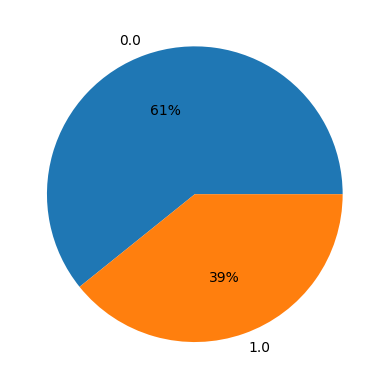

In [15]:
#pie chart za prikaz raspodele po klasama
labels = pd.unique(new_data['Cutoff_Class'])
countByClass = new_data.groupby('Cutoff_Class').size()
#colors = sns.color_palette('pastel')[0:2]
plt.pie(countByClass, labels = labels, autopct='%.0f%%')
plt.show()

Data before oversampling: (2009, 75)
Data after oversampling:  (2442, 75)


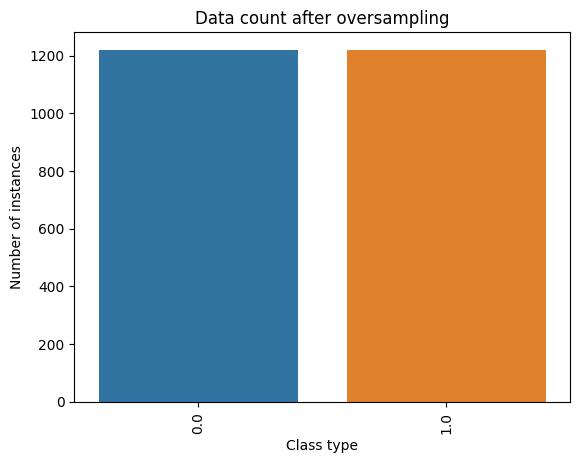

In [16]:
#oversampling sa SMOTE tehnikom
def oversampling(data):
    oversample = SMOTE()
    X_oversample, y_oversample = oversample.fit_resample(data[data.columns.difference(['Cutoff_Class'])], data['Cutoff_Class'])
    data_frame = pd.DataFrame(X_oversample)
    data_frame['Cutoff_Class'] = y_oversample
    print('Data before oversampling:', data.shape)
    print('Data after oversampling: ', X_oversample.shape)
    count_oversample = X_oversample.groupby('Cutoff_Class').size().sort_values()
    sns.barplot(x = labels, y = count_oversample, data = X_oversample)
    plt.title('Data count after oversampling')
    plt.xlabel('Class type')
    plt.xticks(rotation=90)
    plt.ylabel('Number of instances')
    plt.show()
    return data_frame
new_data_balanced = oversampling(new_data)

In [17]:
#pregled outlier vrednosti po kolonama
#detekcija outliera pomocu iqr
def find_outliers(df, col_name):
    q1 = df[col_name].quantile(0.25)
    q3=  df[col_name].quantile(0.75)
    iqr = q3-q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    outliers = df[((df[col_name]<(q1-1.5*iqr)) | (df[col_name]>(q3+1.5*iqr)))]
    return outliers
cols_to_use = new_data[new_data.columns.difference(zero_one)]
total_outlier_num=0
cols = cols_to_use.columns.values
num_cols=[]
for col in cols:
    num = find_outliers(cols_to_use, col)
    num_cols.append(len(num))
new_data_frame = pd.DataFrame()
new_data_frame['Feature']= cols
new_data_frame['Outliers']= num_cols
#print(new_data_frame.sort_values('Outliers', ascending=False))

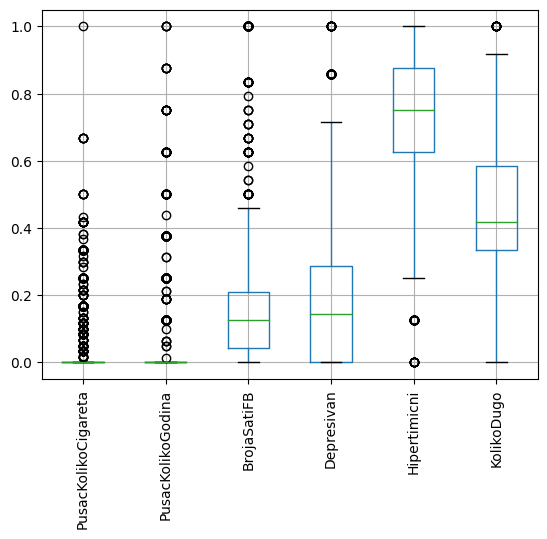

In [18]:
#ima smisla prikazivati outliere kod onih kolona gde se ne ponavljaju vrednosti iz predefinisanog skupa
outlier_cols = ['PusacKolikoCigareta','PusacKolikoGodina','BrojaSatiFB','Depresivan','Hipertimicni','KolikoDugo'] 
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()
#pravimo kopiju da originalni set ne bi bio promenjen
outlier_data_norm = new_data.copy()
outlier_data_robust = new_data.copy()
outlier_data_norm[outlier_cols]= minmax_scaler.fit_transform(new_data[outlier_cols])
outlier_data_robust[outlier_cols]= robust_scaler.fit_transform(new_data[outlier_cols])
#prikaz outliera na boxplot-u
outlier_data_norm[outlier_cols].boxplot(rot=90)
#new_data[outlier_cols].boxplot(rot=90)
plt.show()
#outlier_data_robust[outlier_cols].boxplot(rot=90)

In [19]:
#detekcija i eliminacija outlier vrednosti primenom isolation forest-a
def delete_outliers(data):
    isolation_forest = IsolationForest(n_estimators = 100, contamination = 0.05, max_samples = 'auto')
    outlier_prediction = isolation_forest.fit_predict(data.values)
    print("Number of normal values detected: {}".format(outlier_prediction[outlier_prediction  == 1].sum()))
    print("Number of outliers detected: {}".format(abs(outlier_prediction[outlier_prediction == -1].sum())))
    data_no_outliers = data.copy()
    data_no_outliers['Is_Outlier'] = outlier_prediction
    data_no_outliers.drop(data_no_outliers[(data_no_outliers['Is_Outlier'] == -1)].index, axis = 0, inplace=True)
    data_no_outliers = data_no_outliers[data_no_outliers.columns.difference(['Is_Outlier'])]
    print('Number of values after eliminating outliers: ' + str(len(data_no_outliers)))
    return data_no_outliers
new_data_b_no_outliers = delete_outliers(new_data_balanced)

Number of normal values detected: 2319
Number of outliers detected: 123
Number of values after eliminating outliers: 2319


In [20]:
#normalizacija podataka -> normalizujemo sve kolone osim onih koje imaju samo binarne vrednosti 
cols_to_normalize = input_cols.columns.difference(zero_one)
min_max = MinMaxScaler()
new_data_norm = new_data_b_no_outliers.copy()
new_data_norm[cols_to_normalize] = min_max.fit_transform(new_data_norm[cols_to_normalize])

In [21]:
#standardizacija podataka
cols_to_standardize = input_cols.columns.difference(zero_one)
standard_scaler = StandardScaler()
new_data_standard = new_data_b_no_outliers.copy()
new_data_standard[cols_to_standardize] = standard_scaler.fit_transform(new_data_standard[cols_to_standardize])

In [22]:
#podela na train i test set
X_cols = new_data[new_data.columns.difference(['Cutoff_Class', 'PUIcutoff', 'PUI' ])]
y_col = new_data['Cutoff_Class']

X_cols_preprocessed = new_data_norm[new_data_norm.columns.difference(['Cutoff_Class', 'PUIcutoff', 'PUI' ])]
y_col_preprocessed = new_data_norm['Cutoff_Class']

#treniranje sa neobradjenim i preprocesiranim skupom
X_train, X_test, y_train, y_test = train_test_split(X_cols, y_col, test_size=0.3)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_cols_preprocessed, y_col_preprocessed, test_size=0.2)

# Izbor atributa - Feature selection

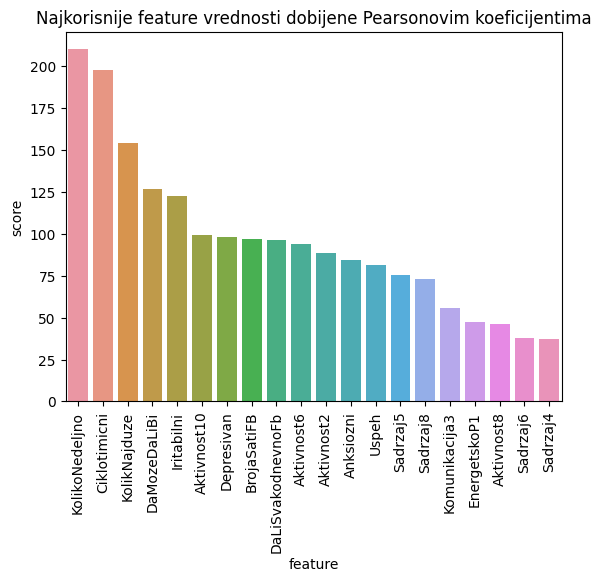

In [23]:
#feature selection sa Pearsonovim koeficijentom, input numericki, output numericki, za klasifikaciju
def feature_selection_pearson(n_features):
    best_features = SelectKBest(score_func = f_regression, k=n_features)
    #calc_features = best_features.fit(input_cols,output_col)
    calc_features = best_features.fit(X_cols_preprocessed,y_col_preprocessed)
    #odabir najboljih feature-a
    usefull_features = pd.DataFrame({'feature' : X_cols_preprocessed.columns.values, 'score' : calc_features.scores_})
    most_usefull_features = usefull_features.sort_values(by=['score'],ascending=False).head(n_features)
    #vizuelizacija dobijenih rezultata
    plt.title('Najkorisnije feature vrednosti dobijene Pearsonovim koeficijentima')
    plt.xlabel('Feature score')
    plt.xticks(rotation=90)
    plt.ylabel('Naziv kolone')

    sns.barplot(x=most_usefull_features['feature'], y=most_usefull_features['score'])
    plt.show()
    feat_to_ret = most_usefull_features['feature']
    return feat_to_ret

results = feature_selection_pearson(20)

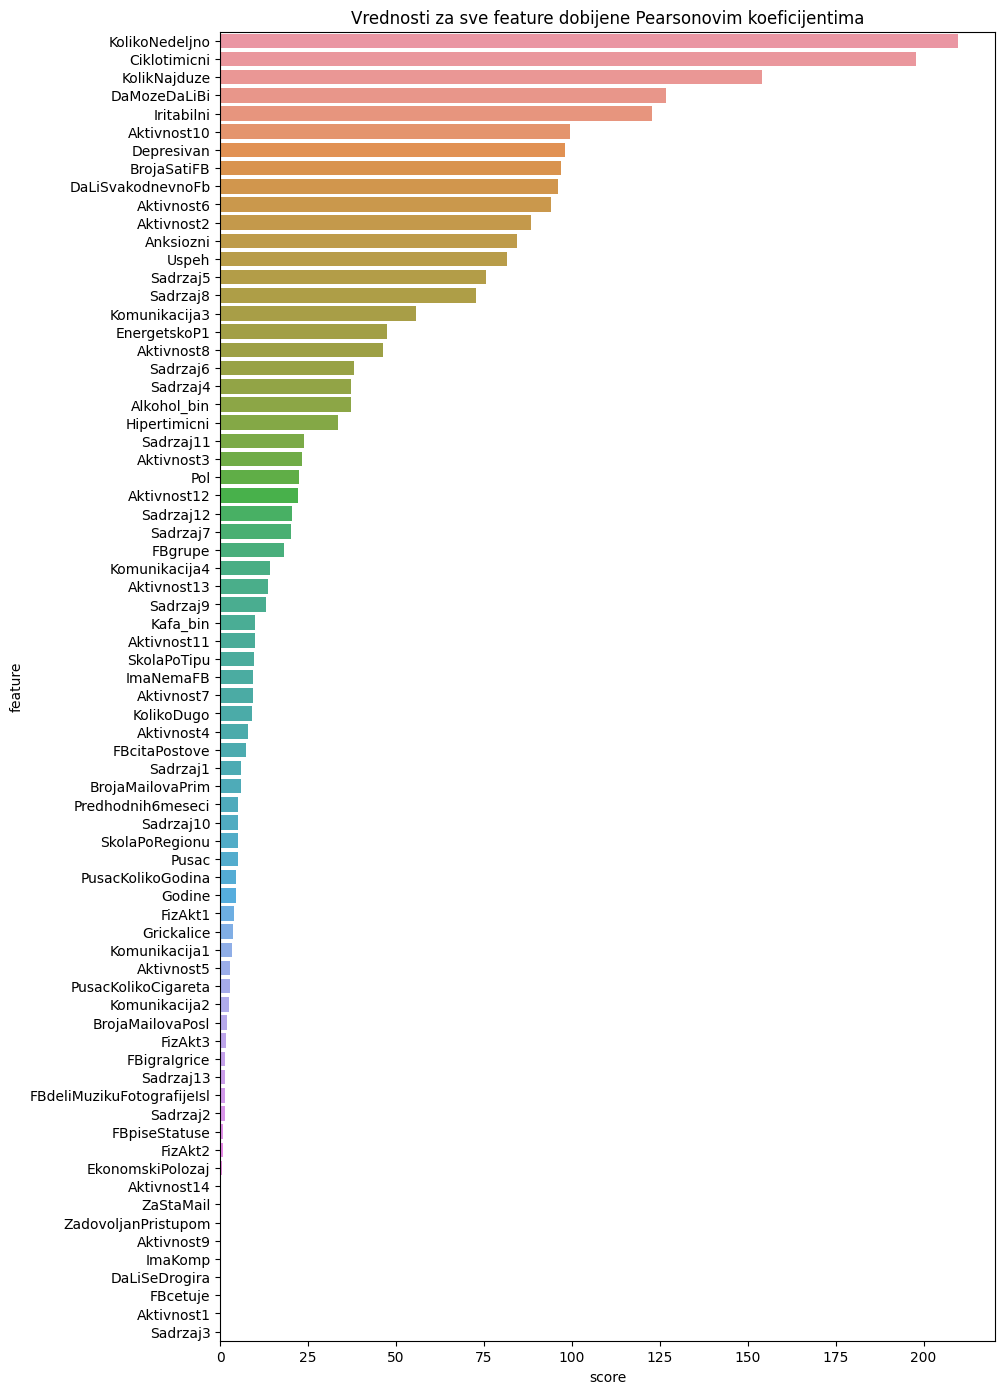

In [24]:
#feature selection sa Pearsonovim koeficijentom, input numericki, output numericki, za klasifikaciju

#varijanta sa prikazom svih atributa, nema negativnih vrednosti

def pearson_results_all():
    best_features = SelectKBest(score_func = f_regression, k=72)
    calc_features = best_features.fit(X_cols_preprocessed, y_col_preprocessed)
    #odabir najboljih feature-a
    usefull_features = pd.DataFrame({'feature' : X_cols_preprocessed.columns.values, 'score' : calc_features.scores_})
    usefull_features = usefull_features.sort_values(by=['score'],ascending=False)
    #vizuelizacija dobijenih rezultata
    plt.figure(figsize=(10,17))
    plt.title('Vrednosti za sve feature dobijene Pearsonovim koeficijentima')
    plt.xlabel('Feature score')
    plt.ylabel('Naziv kolone')

    sns.barplot(y=usefull_features['feature'], x=usefull_features['score'])
    plt.show()
    feat_to_ret = usefull_features['feature']

results = pearson_results_all()

Index(['Aktivnost10', 'BrojaSatiFB', 'Ciklotimicni', 'Cutoff_Class',
       'DaMozeDaLiBi', 'Depresivan', 'Iritabilni', 'KolikNajduze',
       'KolikoNedeljno', 'PUI', 'PUIcutoff'],
      dtype='object')


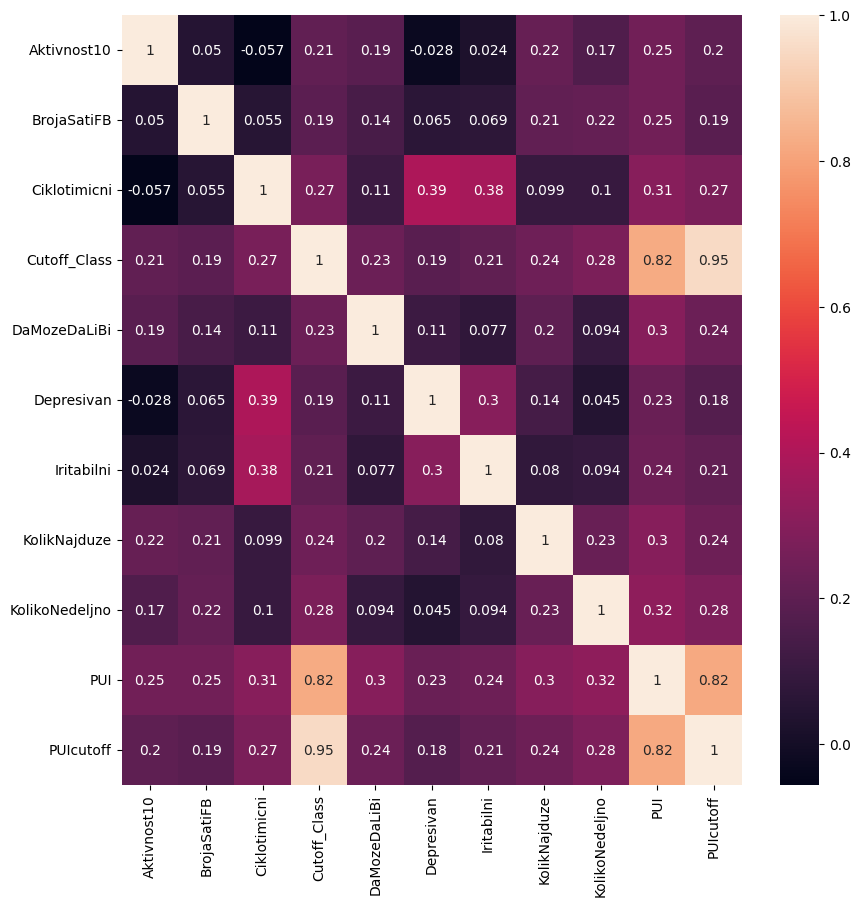

In [25]:
#prikaz heat mape gde se vide koeficijenti korelacije
def correlation_coef(corr_treshold):
    plt.figure(figsize=(10,10))
    correlation = new_data_norm.corr()
    correlation_treshold = correlation['Cutoff_Class']
    good_features = correlation_treshold[abs(correlation_treshold > corr_treshold )]
    print(str(good_features.keys()))
    #print(good_features.sort_values(ascending=False))
    sns.heatmap(new_data[good_features.keys()].corr(), annot=True)
correlation_coef(0.2)

In [26]:
#izarani modeli za testiranje razlicitih metoda za izbor atributa
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
grad_boost_class = GradientBoostingClassifier()

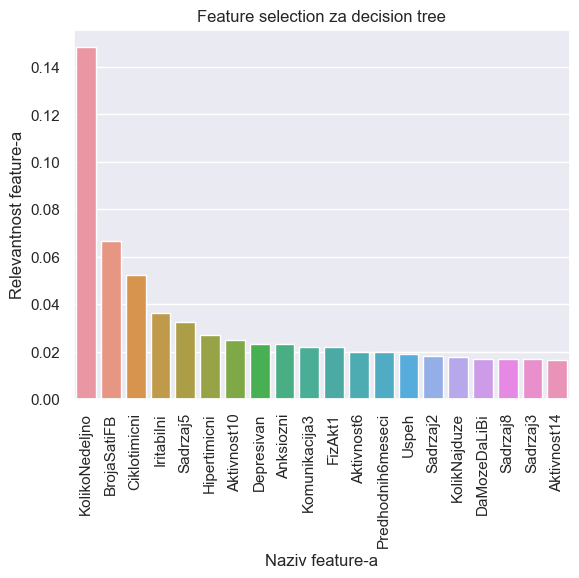

44       KolikoNedeljno
18          BrojaSatiFB
19         Ciklotimicni
40           Iritabilni
62             Sadrzaj5
37         Hipertimicni
1           Aktivnost10
23           Depresivan
15            Anksiozni
47        Komunikacija3
32              FizAkt1
10           Aktivnost6
50    Predhodnih6meseci
69                Uspeh
59             Sadrzaj2
42         KolikNajduze
22         DaMozeDaLiBi
65             Sadrzaj8
60             Sadrzaj3
5           Aktivnost14
Name: attr_names, dtype: object

In [27]:
#feature selection za decision tree
def feature_selection_decision_tree(n_features):
    sns.set()
    decision_tree.fit(X_cols_preprocessed, y_col_preprocessed)
    values = decision_tree.feature_importances_
    attr_names = X_cols_preprocessed.columns.values
    tree_features = pd.DataFrame({'attr_names':attr_names, 'values':values})
    tree_features = tree_features.sort_values(by='values', ascending=False).head(n_features)
    sns.barplot(x = tree_features['attr_names'], y=tree_features['values'])
    title = 'Feature selection za decision tree'
    plt.title(title)
    plt.xlabel('Naziv feature-a')
    plt.xticks(rotation=90)
    plt.ylabel('Relevantnost feature-a')
    plt.show()
    #cuvanje najkorisnijih feature-a
    best_decision_tree_features = tree_features['attr_names']
    return best_decision_tree_features
feature_selection_decision_tree(20)

In [28]:
#prikaz rezultata za sve feature vrednosti, nema negativnih vrednosti
def feature_score_dtc():
    sns.set()
    decision_tree.fit(X_cols_preprocessed, y_col_preprocessed)
    values = decision_tree.feature_importances_
    attr_names = X_cols.columns.values
    tree_features = pd.DataFrame({'attr_names':attr_names, 'values':values})
    tree_features = tree_features.sort_values(by='values', ascending=False)
    return tree_features
print(feature_score_dtc())

                    attr_names    values
44              KolikoNedeljno  0.148260
18                 BrojaSatiFB  0.063859
19                Ciklotimicni  0.050747
40                  Iritabilni  0.037972
62                    Sadrzaj5  0.033505
1                  Aktivnost10  0.025605
23                  Depresivan  0.025516
37                Hipertimicni  0.025011
7                   Aktivnost3  0.023676
47               Komunikacija3  0.021854
32                     FizAkt1  0.019384
59                    Sadrzaj2  0.019280
42                KolikNajduze  0.018268
15                   Anksiozni  0.018155
22                DaMozeDaLiBi  0.017872
50           Predhodnih6meseci  0.017660
9                   Aktivnost5  0.017568
65                    Sadrzaj8  0.017558
34                     FizAkt3  0.016580
61                    Sadrzaj4  0.016035
5                  Aktivnost14  0.015355
69                       Uspeh  0.014673
67              SkolaPoRegionu  0.014046
46              

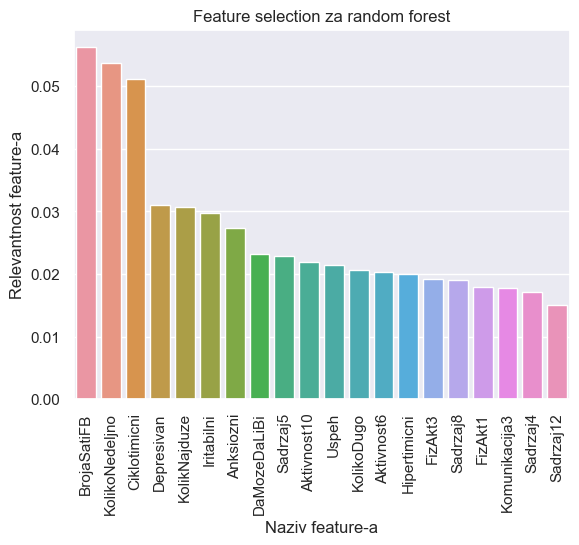

18       BrojaSatiFB
44    KolikoNedeljno
19      Ciklotimicni
23        Depresivan
42      KolikNajduze
40        Iritabilni
15         Anksiozni
22      DaMozeDaLiBi
62          Sadrzaj5
1        Aktivnost10
69             Uspeh
43        KolikoDugo
10        Aktivnost6
37      Hipertimicni
34           FizAkt3
65          Sadrzaj8
32           FizAkt1
47     Komunikacija3
61          Sadrzaj4
57         Sadrzaj12
Name: attr_names, dtype: object

In [29]:
#feature selection za random forest
def feature_selection_random_forest(n_features):
    random_forest.fit(X_cols_preprocessed, y_col_preprocessed)
    values = random_forest.feature_importances_
    attr_names = X_cols_preprocessed.columns.values
    tree_features = pd.DataFrame({'attr_names':attr_names, 'values':values})
    tree_features = tree_features.sort_values(by='values', ascending=False).head(n_features)
    sns.barplot(x = tree_features['attr_names'], y=tree_features['values'])
    title = 'Feature selection za random forest'
    plt.title(title)
    plt.xlabel('Naziv feature-a')
    plt.xticks(rotation=90)
    plt.ylabel('Relevantnost feature-a')
    plt.show()
    #cuvanje najkorisnijih feature-a
    best_random_forest_features = tree_features['attr_names']
    return best_random_forest_features
feature_selection_random_forest(20)

In [30]:
#feature score za random forest, nema negativnih vrednosti
def feature_score_rfc():
    random_forest.fit(X_cols_preprocessed, y_col_preprocessed)
    values = random_forest.feature_importances_
    attr_names = X_cols.columns.values
    tree_features = pd.DataFrame({'attr_names':attr_names, 'values':values})
    tree_features = tree_features.sort_values(by='values', ascending=False)
    return tree_features
    
print(feature_score_rfc())

                    attr_names    values
18                 BrojaSatiFB  0.064703
19                Ciklotimicni  0.051339
44              KolikoNedeljno  0.041489
42                KolikNajduze  0.035509
40                  Iritabilni  0.031288
15                   Anksiozni  0.028165
22                DaMozeDaLiBi  0.025045
23                  Depresivan  0.024733
47               Komunikacija3  0.022558
37                Hipertimicni  0.021531
1                  Aktivnost10  0.021410
69                       Uspeh  0.021303
10                  Aktivnost6  0.020539
65                    Sadrzaj8  0.020382
62                    Sadrzaj5  0.019299
34                     FizAkt3  0.019174
43                  KolikoDugo  0.019069
32                     FizAkt1  0.017185
61                    Sadrzaj4  0.016879
8                   Aktivnost4  0.015250
21           DaLiSvakodnevnoFb  0.014445
63                    Sadrzaj6  0.014191
57                   Sadrzaj12  0.014161
64              

In [31]:
#feature selection sa LassoCV modelom 
def feature_selection_lasso_cv(n_features):
    lasso = LassoCV(cv=3)                                                   
    lasso.fit(X_cols_preprocessed, y_col_preprocessed)      
    lasso_values = lasso.coef_
    attr_names = X_cols_preprocessed.columns.values
    #lasso_features = pd.DataFrame({'attr_names':attr_names, 'values': lasso_values})
    lasso_features_abs = pd.DataFrame({'attr_names':attr_names, 'values': abs(lasso_values)})
    lasso_features_abs = lasso_features_abs.sort_values(by='values', ascending=False).head(n_features)       
    #cuvanje najkorisnijih feature-a
    best_lasso_features_abs = lasso_features_abs['attr_names']
    return best_lasso_features_abs
feature_selection_lasso_cv(20)

19         Ciklotimicni
44       KolikoNedeljno
37         Hipertimicni
69                Uspeh
22         DaMozeDaLiBi
18          BrojaSatiFB
62             Sadrzaj5
15            Anksiozni
21    DaLiSvakodnevnoFb
42         KolikNajduze
65             Sadrzaj8
10           Aktivnost6
61             Sadrzaj4
40           Iritabilni
1           Aktivnost10
47        Komunikacija3
51                Pusac
27        FBcitaPostove
6            Aktivnost2
23           Depresivan
Name: attr_names, dtype: object

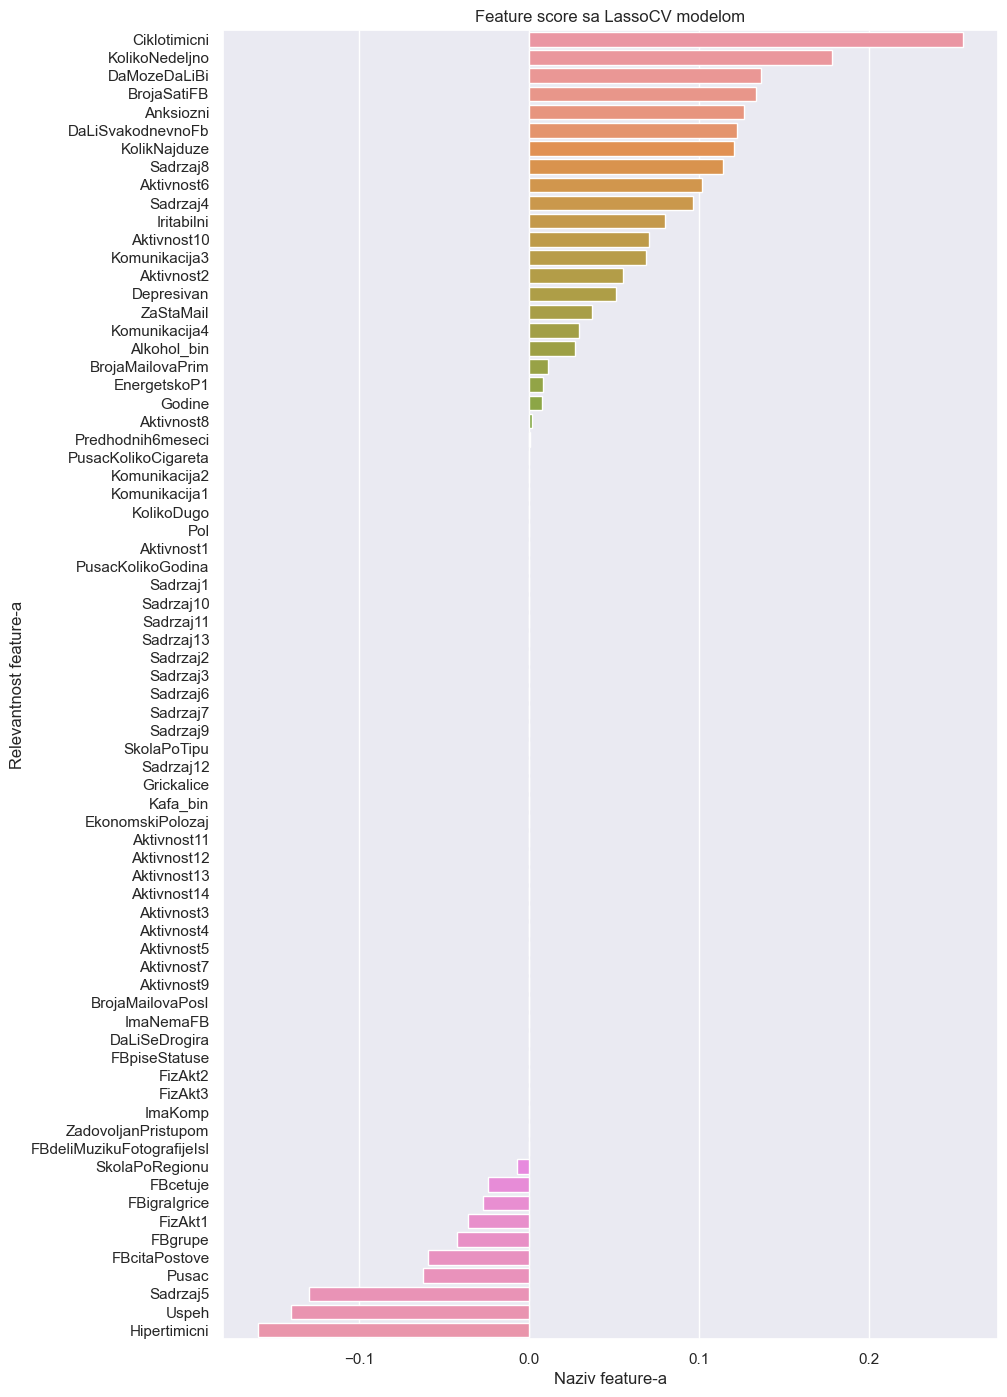

In [32]:
#feature score sa LassoCV modelom 
def feature_score_lasso_cv():
    lasso = LassoCV(cv=3)                                                   
    lasso.fit(X_cols_preprocessed, y_col_preprocessed)      
    lasso_values = lasso.coef_
    attr_names = X_cols_preprocessed.columns.values
    lasso_features = pd.DataFrame({'attr_names':attr_names, 'values':lasso_values})
    lasso_features = lasso_features.sort_values(by='values', ascending=False)  
    plt.figure(figsize=(10,17))
    sns.barplot(y = lasso_features['attr_names'], x=lasso_features['values'])
    title = 'Feature score sa LassoCV modelom'
    plt.title(title)
    plt.xlabel('Naziv feature-a')
    plt.ylabel('Relevantnost feature-a')
    plt.show()
feature_score_lasso_cv()

In [33]:
#feature selection koriscenjem ElasticNetCV modela
def feature_selection_elasticnet_cv(n_features):
    el_net = ElasticNetCV(cv=3)
    el_net.fit(X_cols_preprocessed, y_col_preprocessed)
    el_net_values = el_net.coef_
    attr_names = X_cols_preprocessed.columns.values
    el_net_features = pd.DataFrame({'attr_names':attr_names, 'values': abs(el_net_values)})
    el_net_features = el_net_features.sort_values(by='values', ascending=False).head(n_features)       
    #cuvanje najkorisnijih feature-a
    best_el_net_features = el_net_features['attr_names']
    return best_el_net_features
print(feature_selection_elasticnet_cv(20))

19         Ciklotimicni
44       KolikoNedeljno
37         Hipertimicni
69                Uspeh
22         DaMozeDaLiBi
18          BrojaSatiFB
62             Sadrzaj5
15            Anksiozni
21    DaLiSvakodnevnoFb
42         KolikNajduze
65             Sadrzaj8
10           Aktivnost6
61             Sadrzaj4
40           Iritabilni
1           Aktivnost10
47        Komunikacija3
51                Pusac
27        FBcitaPostove
6            Aktivnost2
23           Depresivan
Name: attr_names, dtype: object


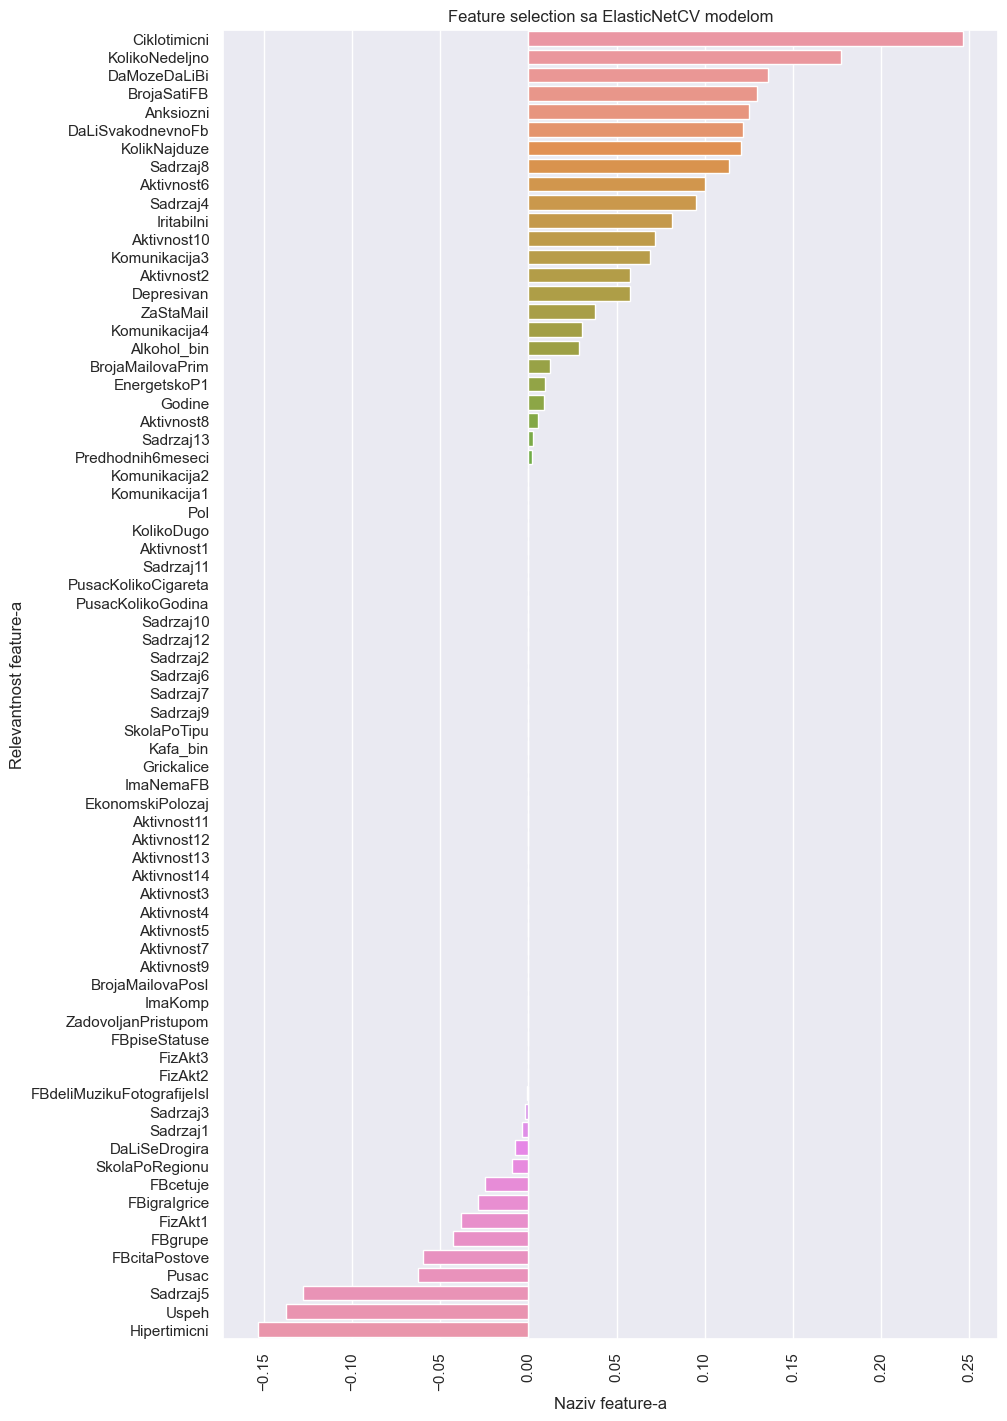

In [34]:
#feature selection koriscenjem ElasticNetCV modela
def feature_score_elasticnet_cv():
    el_net = ElasticNetCV(cv=3)
    el_net.fit(X_cols_preprocessed, y_col_preprocessed)
    el_net_values = el_net.coef_
    attr_names = X_cols_preprocessed.columns.values
    el_net_features = pd.DataFrame({'attr_names':attr_names, 'values':el_net_values})
    el_net_features = el_net_features.sort_values(by='values', ascending=False)  
    plt.figure(figsize=(10,17))
    sns.barplot(y = el_net_features['attr_names'], x =el_net_features['values'])
    title = 'Feature selection sa ElasticNetCV modelom'
    plt.title(title)
    plt.xlabel('Naziv feature-a')
    plt.xticks(rotation=90)
    plt.ylabel('Relevantnost feature-a')
    plt.show()
feature_score_elasticnet_cv()

Classification report sa svim feature-ima za PCA: 
              precision    recall  f1-score   support

         0.0       0.67      0.85      0.75       364
         1.0       0.62      0.37      0.46       239

    accuracy                           0.66       603
   macro avg       0.65      0.61      0.61       603
weighted avg       0.65      0.66      0.64       603

Classification report sa redukovanim feature-ima za PCA: 
              precision    recall  f1-score   support

         0.0       0.68      0.72      0.70       364
         1.0       0.53      0.47      0.50       239

    accuracy                           0.62       603
   macro avg       0.60      0.60      0.60       603
weighted avg       0.62      0.62      0.62       603



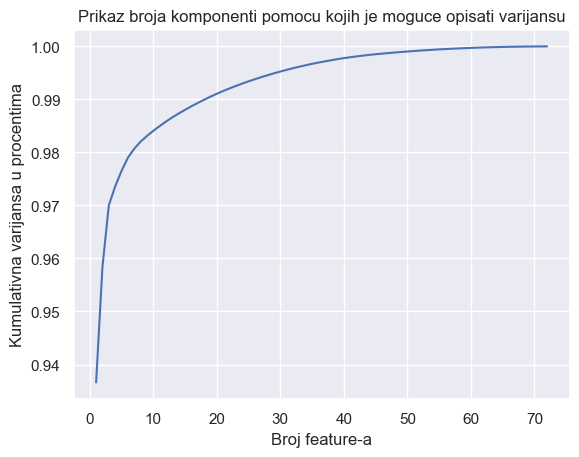

In [35]:
#primena principal component analysis na problem redukcije feature-a
pca = PCA(n_components = None)
X_train_new = pca.fit_transform(X_train)
X_test_new = pca.fit_transform(X_test)

fig, ax = plt.subplots()
x = np.arange(1,73, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.xlabel('Broj feature-a')
plt.ylabel('Kumulativna varijansa u procentima')
plt.title('Prikaz broja komponenti pomocu kojih je moguce opisati varijansu')
plt.plot(x,y)
clr = RandomForestClassifier()
clr.fit(X_train_new, y_train)

y_pred_pca = clr.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred_pca)
print('Classification report sa svim feature-ima za PCA: \n' + (classification_report(y_test, y_pred_pca)))

#broj komponenti predstavljen vrednoscu nakon koje se uocava zaravnjenje krive
pca = PCA(n_components = 5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)
clr = RandomForestClassifier()
clr.fit(X_train_pca, y_train)

y_pred_pca = clr.predict(X_test_pca)
print('Classification report sa redukovanim feature-ima za PCA: \n' + (classification_report(y_test, y_pred_pca)))

In [36]:
#primena genetskih algoritama za selekciju atributa
#feature selection koriscenjem genetskih algoritama
clf = RandomForestClassifier()
evolved_estimator = GAFeatureSelectionCV(
    estimator=clf,
    cv=3,
    scoring="accuracy",
    population_size=30,
    generations=20,
    n_jobs=-1,
    verbose=True,
    keep_top_k=2,
    elitism=True,
)
evolved_estimator.fit(X_train_p, y_train_p)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	30    	0.769656	0.0126353  	0.789771   	0.738015   
1  	60    	0.7785  	0.00744813 	0.789774   	0.760661   
2  	60    	0.779559	0.00606264 	0.789774   	0.768737   
3  	60    	0.776806	0.00987428 	0.788148   	0.747169   
4  	60    	0.776539	0.00922173 	0.787612   	0.752021   
5  	60    	0.778659	0.00901121 	0.791923   	0.754721   
6  	60    	0.777168	0.00911144 	0.790311   	0.761194   
7  	60    	0.776703	0.00997609 	0.790311   	0.750948   
8  	60    	0.780368	0.00782345 	0.795154   	0.764423   
9  	60    	0.780513	0.00842439 	0.795154   	0.761739   
10 	60    	0.783441	0.00793311 	0.79084    	0.761194   
11 	60    	0.778698	0.0118142  	0.791386   	0.747176   
12 	60    	0.779468	0.0108965  	0.79084    	0.747169   
13 	60    	0.780314	0.0108253  	0.790846   	0.756875   
14 	60    	0.782166	0.00997659 	0.790848   	0.751487   
15 	60    	0.782365	0.00927239 	0.79084    	0.760657   
16 	60    	0.78265 	0.0100052  	0.792454   	0.75

GAFeatureSelectionCV(estimator=RandomForestClassifier(), generations=20,
                     keep_top_k=2, n_jobs=-1, population_size=30,
                     scoring='accuracy')

In [37]:
#feature selection koriscenjem genetskih alogiritama 
gen_opt_features = evolved_estimator.best_features_
gen_df = pd.DataFrame({'feature': X_train.columns, 'is_used':gen_opt_features})

def highlight_cells(val):
    color = 'yellow' if val == True else ''
    return 'background-color: {}'.format(color)

selected_features = gen_df[gen_df['is_used'] == True]['feature']
gen_df.style.applymap(highlight_cells)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(gen_df)

                       feature  is_used
0                   Aktivnost1     True
1                  Aktivnost10    False
2                  Aktivnost11    False
3                  Aktivnost12     True
4                  Aktivnost13     True
5                  Aktivnost14     True
6                   Aktivnost2    False
7                   Aktivnost3     True
8                   Aktivnost4    False
9                   Aktivnost5     True
10                  Aktivnost6     True
11                  Aktivnost7    False
12                  Aktivnost8     True
13                  Aktivnost9     True
14                 Alkohol_bin     True
15                   Anksiozni     True
16            BrojaMailovaPosl    False
17            BrojaMailovaPrim     True
18                 BrojaSatiFB     True
19                Ciklotimicni     True
20               DaLiSeDrogira    False
21           DaLiSvakodnevnoFb    False
22                DaMozeDaLiBi     True
23                  Depresivan    False


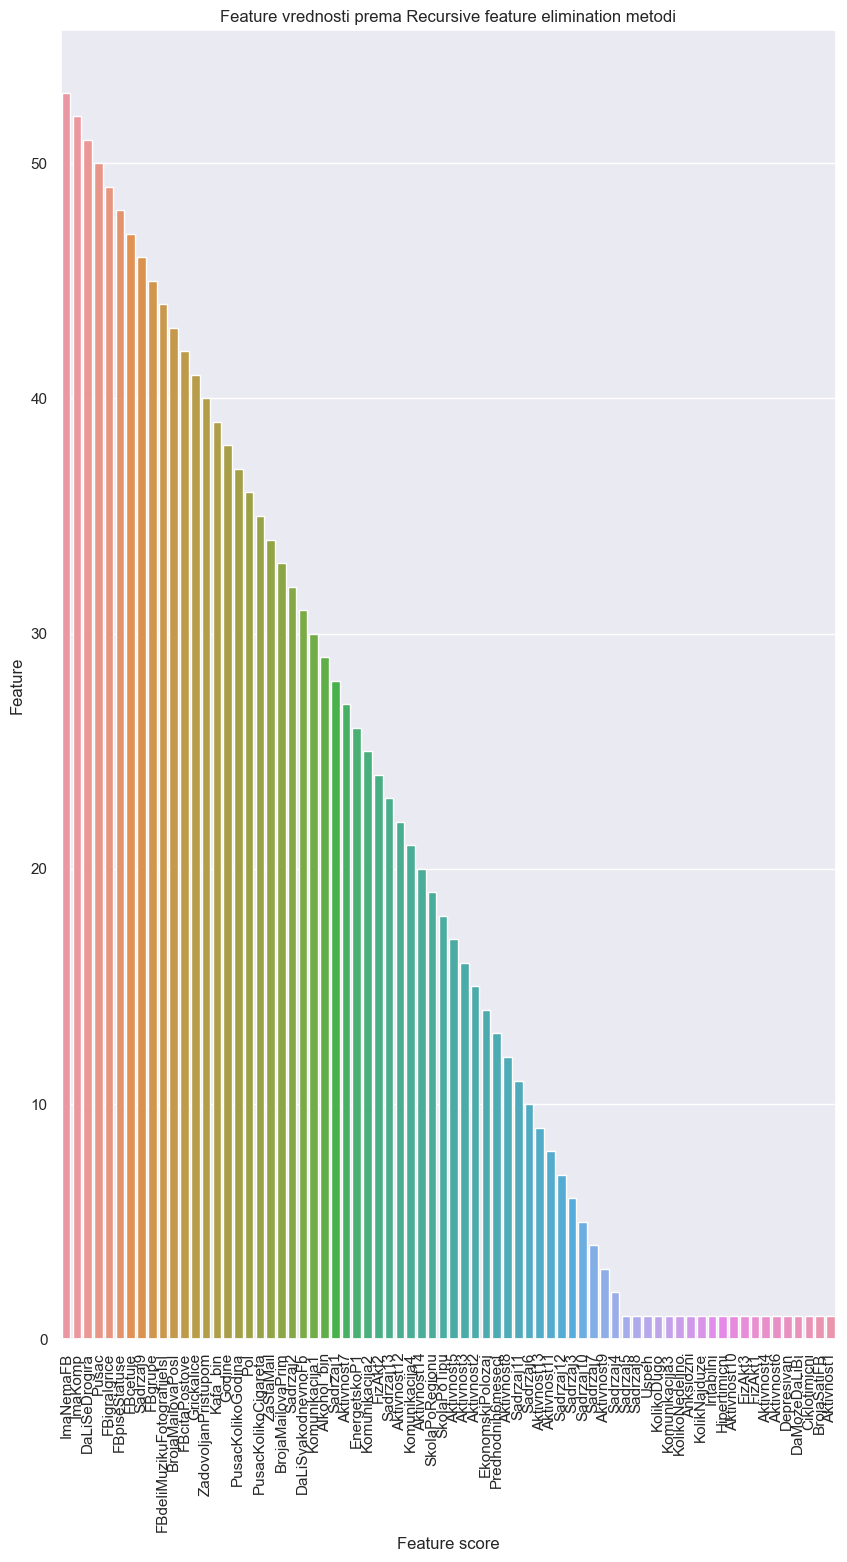

39                     ImaNemaFB
38                       ImaKomp
20                 DaLiSeDrogira
51                         Pusac
30                  FBigraIgrice
31                 FBpiseStatuse
26                      FBcetuje
66                      Sadrzaj9
29                       FBgrupe
28    FBdeliMuzikuFotografijeIsl
16              BrojaMailovaPosl
27                 FBcitaPostove
36                    Grickalice
71           ZadovoljanPristupom
41                      Kafa_bin
35                        Godine
53             PusacKolikoGodina
49                           Pol
52           PusacKolikoCigareta
70                     ZaStaMail
Name: Feature, dtype: object

In [38]:
#primena Rekurzivne eliminacije atributa 
def recursive_feature_elimination(ml_model, n_features):
    model = ml_model
    rfe = RFE(estimator = model, n_features_to_select = n_features)
    fit_model = rfe.fit(X_train_p, y_train_p)
    feature_score = fit_model.ranking_

    features = pd.DataFrame({'Feature' : input_cols.columns.values, 'Feature score' : feature_score})
    features = features.sort_values(by=['Feature score'] , ascending=False)
    plt.figure(figsize=(10,17))
    sns.barplot(x=features['Feature'], y=features['Feature score'])
    plt.title('Feature vrednosti prema Recursive feature elimination metodi')
    plt.xlabel('Feature score')
    plt.xticks(rotation=90)
    plt.ylabel('Feature')
    plt.show()

    best_recursive_features = features.head(n_features)
    return best_recursive_features['Feature']
    
recursive_feature_elimination(RandomForestClassifier(), 20)

In [41]:
#primena eli5 biblioteke za Explainable AI
model = random_forest.fit(X_train_p, y_train_p)
#prikaz globalne interpretabilnosti
eli5.show_weights(random_forest, feature_names = list(input_cols.columns))

In [40]:
#prikaz globalne interpretabilnosti uz Permutation Importance
permutation = PermutationImportance(random_forest, scoring = 'accuracy')
permutation_model = permutation.fit(X_train_p, y_train_p)
eli5.show_weights(permutation_model, feature_names = list(input_cols.columns))

In [63]:
#prikaz lokalne interpretabilnosti za datu intancu
eli5.show_prediction(random_forest, X_test_p.iloc[20], 
                     feature_names = list(input_cols.columns),
                     show_feature_values = True)

In [43]:
#primena LIME biblioteke za Explainable AI
class_unique = new_data_norm['Cutoff_Class'].unique()
lime_explainer = lime_tabular.LimeTabularExplainer(new_data_norm[input_cols.columns].astype(int).values, 
                                                   mode = 'classification', 
                                                   class_names = class_unique, 
                                                   training_labels = new_data_norm['Cutoff_Class'],
                                                   feature_names = list(input_cols.columns))
#biramo konkretnu instancu za objasnjenje izbora atributa
instance_to_explain = X_test_p.iloc[20]
model = random_forest.fit(X_train_p, y_train_p)
exp_lime = lime_explainer.explain_instance(instance_to_explain, model.predict_proba, num_features=10)
exp_lime.show_in_notebook()

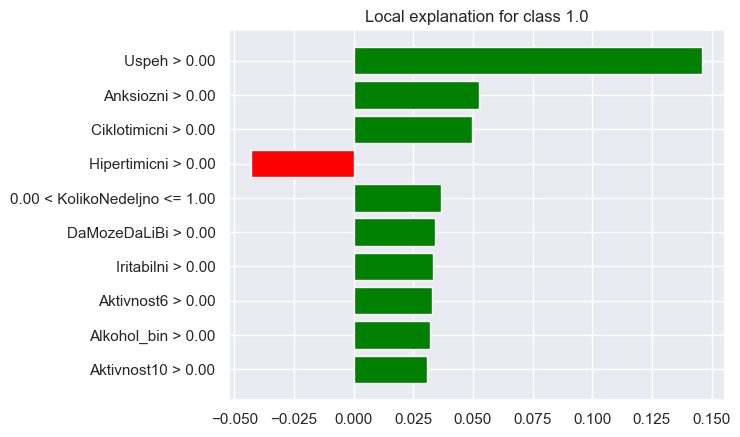

In [44]:
exp_lime.as_pyplot_figure().show()

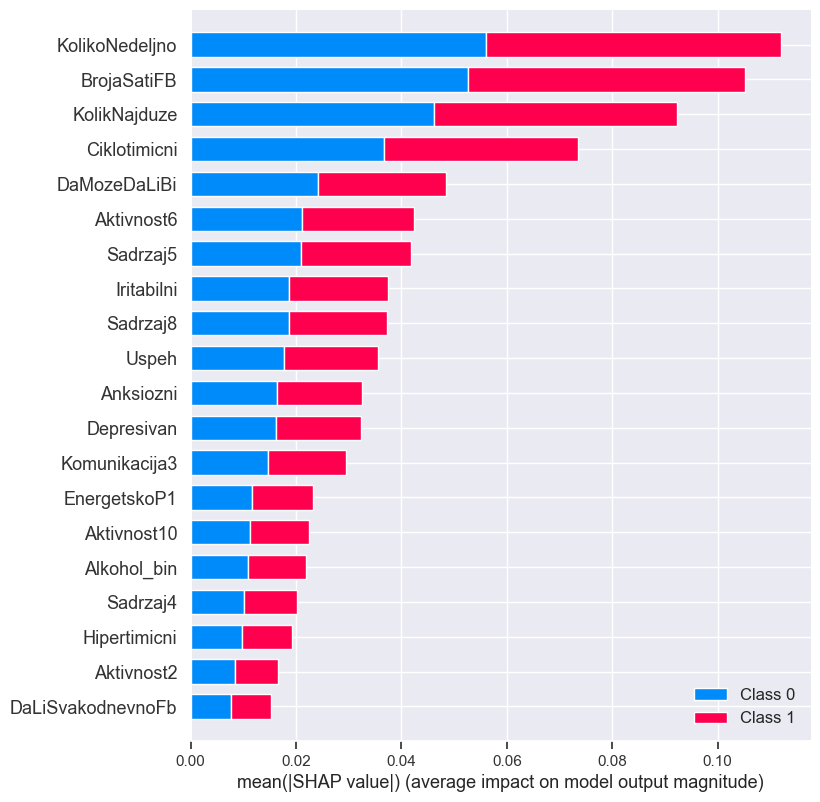

In [45]:
#primena SHAP biblioteke za Explainable AI
model = random_forest.fit(X_train_p, y_train_p)
shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(X_test_p)
#posmatramo uticaj atributa na model, posmatramo uticaj na svaku klasu
shap.summary_plot(shap_values, X_train_p)

In [46]:
#primena SHAP biblioteke koriscenjem force_plot-a
shap.initjs()
shap.plots.force(shap_explainer.expected_value[0], shap_values[0], feature_names = list(input_cols.columns))

In [72]:
#vizuelizacija pomocu SHAP biblioteke za pojedinacnu instancu
shap_explainer = shap.Explainer(model, X_train_p)
shap_values = shap_explainer.shap_values(X_train_p.iloc[20])
shap.force_plot(shap_explainer.expected_value[0], shap_values[0], X_test.iloc[20])